# 동물 이미지 Segmentation 챌린지

> 오픈소스 AI 응용 (2025-2)



In [19]:
#==========================================================
#  Copyright (c) 2025 Boeun Kim / Dankook University
#  All rights reserved.
#
#  File: 2025_pet_segmentation_base_code.ipynb
#  Description: This file was created for the Open Source AI
#               Applications course at Dankook University.
#
#  Author: Boeun Kim
#  Date: 2025-10-30
#
#  License: MIT License
#
#  Note: This project uses a modified version of the
#        Oxford-IIIT Pet Dataset. The original dataset
#        is subject to its own license:
#        "Oxford-IIIT Pet Dataset" © University of Oxford
#==========================================================

# 데이터셋 준비

In [20]:
#from google.colab import drive
#drive.mount('/content/drive')
# 구글 드라이브의 데이터셋 zip파일을 임시 폴더로 복사 (데이터셋 로드를 빠르게 해줌)
#!cp "/content/drive/MyDrive/Colab Notebooks/project/dataset/train.zip" /content/

In [21]:
# 압축 해제
#!unzip /content/train.zip -d /content/dataset

In [22]:
# 압축이 잘 해제되었는지 확인
#!ls /content/dataset

# Configuration (하이퍼파라미터, 경로 등 설정)

In [ ]:
import os
import torch

# 고정되어야 하는 것. 바꾸지 말 것
IMAGE_SIZE = (256, 256)
N_CLASSES = 3  # trimap은 각 픽셀이 배경, 가장자리, 동물부분 이렇게 3개 중 하나의 클래스로 배정된 것

# Seeds
torch.manual_seed(0)

# Device settings
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
IMAGE_PATH = 'train/images'
MAP_PATH = 'train/trimaps'

# Learning parameters
BATCH_SIZE = 16
LEARNING_RATE = 0.0005
EPOCHS = 1000

# Output paths
OUTPUT_PATH = 'train/output'
if not os.path.exists(OUTPUT_PATH):
  os.mkdir(OUTPUT_PATH)
MODEL_PATH = os.path.join(OUTPUT_PATH, 'model_weight.pth')
HISTORY_PATH = os.path.join(OUTPUT_PATH, 'history.pickle')
HISTORY_PLOT_PATH = os.path.join(OUTPUT_PATH, 'history.png')  # 드라이브에 저장하고 싶다면 경로를 변경해야 함
HISTORY_LOGPLOT_PATH = os.path.join(OUTPUT_PATH, 'loghistory.png') 
PRED_PLOT_PATH = os.path.join(OUTPUT_PATH, 'pred.png')

# 데이터셋 클래스

In [24]:
import torch
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class TrimapsDataset(Dataset):
  def __init__(self, img_path, map_path='', test=False):
    super().__init__()

    self.istest=test

    # 이미지 경로의 리스트 생성
    self.img_path_list = sorted([
        os.path.join(img_path, name)
        for name in os.listdir(img_path)
        if name.endswith('.jpg')
    ])

    # 맵 경로의 리스트 생성, train 데이터에만 gt 맵 존재
    if not self.istest:
      self.map_path_list = sorted([
          os.path.join(map_path, name)
          for name in os.listdir(map_path)
          if name.endswith('.png')
      ])

    # 이미지 transform 정의 (리사이즈, 텐서로 변환)
    self.transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
    ])

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):

    image_path = self.img_path_list[idx]
    # 데이터 id 추출. 결과제출시 필요
    data_id = image_path.split('/')[-1].split('.')[0].split('_')[-1]

    # 이미지 열어 RGB로 변경
    image = Image.open(image_path).convert('RGB')
    # 이미지 transform 적용
    image = self.transform(image)

    # train 데이터에만 gt 맵 존재
    if not self.istest:
      map_path = self.map_path_list[idx]
      # 맵 열어 grayscale 로 변경
      map = Image.open(map_path).convert('L')
      # 맵 transform 적용
      map = self.transform(map)
      # map은 0과 1 사이의 값으로 되어있으므로 255를 곱해 정수로 만듦
      map = map * 255
      map = map.squeeze().to(torch.int64)
      # GT 라벨은 1, 2, 3인데 분류 편의성을 위해 0, 1, 2로 변경
      map -= 1
      return image, map

    return image, data_id  # 채점을 위해 테스트 모드에서는 데이터 ID와 함께 반환



# 모델 클래스

In [25]:
from torch import nn

class BaseModel(nn.Module):
    def __init__(self, in_channel, out_channel, img_size):
        super().__init__()
        self.img_size = img_size

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channel, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, out_channel, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 학습 함수

In [26]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import time
import pickle

def train(model, train_loader):

  model.train()

  loss_fn = CrossEntropyLoss()
  optim = Adam(model.parameters(), lr=LEARNING_RATE)

  history = {'train_loss': []}
  start_time = time.time()

  for epoch in range(EPOCHS):
    print('EPOCH: {}'.format(epoch))
    train_loss = 0.

    for i, (images, targets) in enumerate(train_loader):
      images, targets = images.to(DEVICE), targets.to(DEVICE)

      pred = model(images)
      loss = loss_fn(pred, targets)

      optim.zero_grad()
      loss.backward()
      optim.step()

      train_loss += loss*len(images)

    avg_train_loss = train_loss/len(train_loader.dataset)
    print('TRAIN LOSS: {}'.format(avg_train_loss))
    history['train_loss'].append(avg_train_loss.cpu().detach().numpy())

  # 학습 시간 측정
  end_time = time.time() - start_time
  print('Total time: {}s'.format(end_time))

  # 학습된 모델 파라미터 저장
  torch.save(model.state_dict(), MODEL_PATH)

  # Loss 그래프를 만들기 위한 히스토리 저장
  with open(HISTORY_PATH, 'wb', ) as f:
      pickle.dump(history, f)

# 학습 실행

In [27]:
from torch.utils.data import DataLoader

train_set = TrimapsDataset(IMAGE_PATH, MAP_PATH, test=False)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model = BaseModel(3, N_CLASSES, IMAGE_SIZE)
model = model.to(DEVICE)

# train 함수 실행
train(model, train_loader)

EPOCH: 0
TRAIN LOSS: 0.9187632203102112
EPOCH: 1
TRAIN LOSS: 0.8382911682128906
EPOCH: 2
TRAIN LOSS: 0.8220019936561584
EPOCH: 3
TRAIN LOSS: 0.811012327671051
EPOCH: 4
TRAIN LOSS: 0.8037053942680359
EPOCH: 5
TRAIN LOSS: 0.8004283308982849
EPOCH: 6
TRAIN LOSS: 0.7980006337165833
EPOCH: 7
TRAIN LOSS: 0.7926144599914551
EPOCH: 8
TRAIN LOSS: 0.7919988036155701
EPOCH: 9
TRAIN LOSS: 0.7886962890625
Total time: 147.06068587303162s


# 평가함수

In [28]:
# 평가 메트릭인 mIoU 계산 과정
def compute_iou_tensor(pred_map, target_map):
    intersection = (pred_map & target_map).sum(dim=(1, 2)).float()
    union = (pred_map | target_map).sum(dim=(1, 2)).float()
    iou = torch.where(union > 0, intersection / union, torch.ones_like(union))
    return iou

def eval(model, train_loader):
    model.eval()
    total_iou = torch.zeros(N_CLASSES).to(DEVICE)
    total_samples = 0

    with torch.no_grad():
        for i, (images, targets) in enumerate(train_loader):
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 클래스별 mIoU 계산
            for cls in range(N_CLASSES):
                pred_map = (preds == cls)
                target_map = (targets == cls)

                iou = compute_iou_tensor(pred_map, target_map)
                total_iou[cls] += iou.sum()

            total_samples += images.size(0)

    mean_iou_per_class = total_iou / total_samples
    mIoU = mean_iou_per_class.mean().item()

    print(f"[EVAL] mIoU: {mIoU:.4f}")
    return mIoU

# 학습 데이터의 평가 결과 확인
챌린지 결과는 테스트 데이터에서 같은 방법으로 평가됨

In [29]:
model = BaseModel(3, N_CLASSES, IMAGE_SIZE)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)

eval(model, train_loader)

C:\Users\YoonHyeon\AppData\Local\Temp\ipykernel_34464\971299311.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


[EVAL] mIoU: 0.3376


0.33759674429893494

#결과 제출
테스트 데이터에 대해 모델 수행 후 결과 파일 생성.

드라이브에 저장된 submission.csv 파일을 챌린지 사이트에 제출.

In [30]:
import numpy as np
import pandas as pd

# 테스트 데이터 다운로드 & unzip
#drive.mount('/content/drive')
#!cp "/content/drive/MyDrive/Colab Notebooks/project/dataset/test.zip" /content/
#!unzip /content/test.zip -d /content/testset

# RLE (Run Length Encoding) 함수. 파일 제출 형식을 맞추기 위해 필요. 수정하지 말 것
def rle_encode(mask):
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_rle(model, test_loader, save_path):
  model.eval()

  image_ids = []
  image_paths = []
  class_ids = []
  rles = []

  with torch.no_grad():
    for i, (images, data_id) in enumerate(test_loader):
      images = images.to(DEVICE)

      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)
      preds = preds.cpu().numpy()  # numpy로 변환

      for b in range(preds.shape[0]):
          pred_mask = preds[b] + 1  # 모델에서 편의를 위해 0, 1, 2로 변환했었기 때문에 되돌리기 위해 +1
          image_id = 'TEST_'+data_id[b]

          # 클래스별 RLE 인코딩 (1=foreground, 2=border, 3=background)
          for class_id in [1, 2, 3]:
              mask = (pred_mask == class_id).astype(np.uint8)
              rle = rle_encode(mask) if mask.sum() > 0 else ''

              image_ids.append(image_id)
              class_ids.append(class_id)
              rles.append(rle)

    # DataFrame 저장
    df = pd.DataFrame({
        'image_id': image_ids,
        'class_id': class_ids,
        'rle': rles
    })
    df.to_csv(save_path, index=False)
    print(f"RLE CSV file saved : {save_path}")

    return df

In [32]:
# Data paths
TEST_PATH = 'images'
SUBMISSION_FILE_PATH = 'submission/submission.csv'

test_set = TrimapsDataset(TEST_PATH, '', test=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

model = BaseModel(3, N_CLASSES, IMAGE_SIZE)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)

get_rle(model, test_loader, SUBMISSION_FILE_PATH)

C:\Users\YoonHyeon\AppData\Local\Temp\ipykernel_34464\1533030343.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


RLE CSV file saved : submission/submission.csv


,image_id,class_id,rle
0,TEST_0000,1,537 4 556 3 577 4 585 26 616 5 627 7 635 4 666...
1,TEST_0000,2,1 536 541 15 561 16 581 4 621 6 634 1 639 16 6...
2,TEST_0000,3,559 2 611 5 655 1 815 1 867 4 1067 2 1072 3 10...
3,TEST_0001,1,663 1 665 18 693 19 713 6 731 8 747 6 921 18 9...
4,TEST_0001,2,1 662 664 1 683 10 712 1 719 12 739 8 753 168 ...
...,...,...,...
3325,TEST_1108,2,1 514 517 1 521 14 584 1 619 4 624 3 628 6 635...
3326,TEST_1108,3,10441 1 10443 5 10449 2 10697 6 10705 1 10950 ...
3327,TEST_1109,1,515 2 521 2 637 6 709 6 723 4 729 6 737 2 747 ...
3328,TEST_1109,2,1 514 517 4 523 114 643 66 715 8 727 2 735 2 7...


# [참고 활용] Loss 그래프 확인 및 Trimap 도출 결과 확인



Loss 그래프 확인

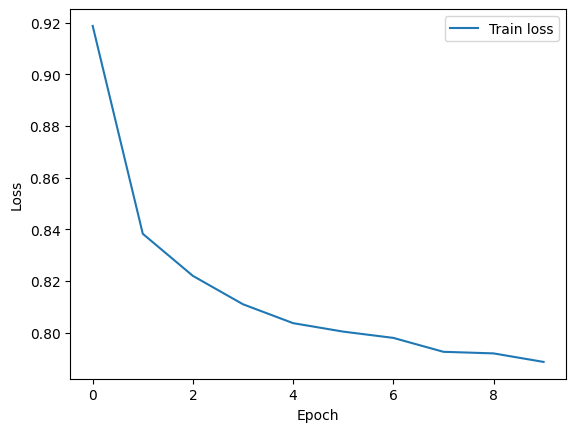

In [33]:
import matplotlib.pyplot as plt

# 저장한 Loss 히스토리 로드
with open(HISTORY_PATH, 'rb') as f:
    model_history = pickle.load(f)

# 그래프 만들어 이미지로 저장
plt.figure()
plt.plot(model_history['train_loss'], label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(HISTORY_PLOT_PATH)

# 로그 스케일 그래프

In [34]:
import matplotlib.pyplot as plt
import pickle

# 저장한 Loss 히스토리 로드
with open(HISTORY_PATH, 'rb') as f:
    model_history = pickle.load(f)

# 그래프 만들어 이미지로 저장
plt.figure()
plt.plot(model_history['train_loss'], label='Train loss')

# 로그 스케일 설정
plt.yscale('log')

plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend(loc='upper right')
plt.title('Training Loss (Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig(HISTORY_LOGPLOT_PATH, dpi=200, bbox_inches='tight')
plt.close()

Trimap 도출 결과 확인

본 코드는 학습에 사용한 이미지를 랜덤하게 선택해 확인해 보는 것으로, 테스트 이미지에 좋은 성능을 보이는지와는 일치하지 않을 수 있음.

C:\Users\YoonHyeon\AppData\Local\Temp\ipykernel_34464\3820901342.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


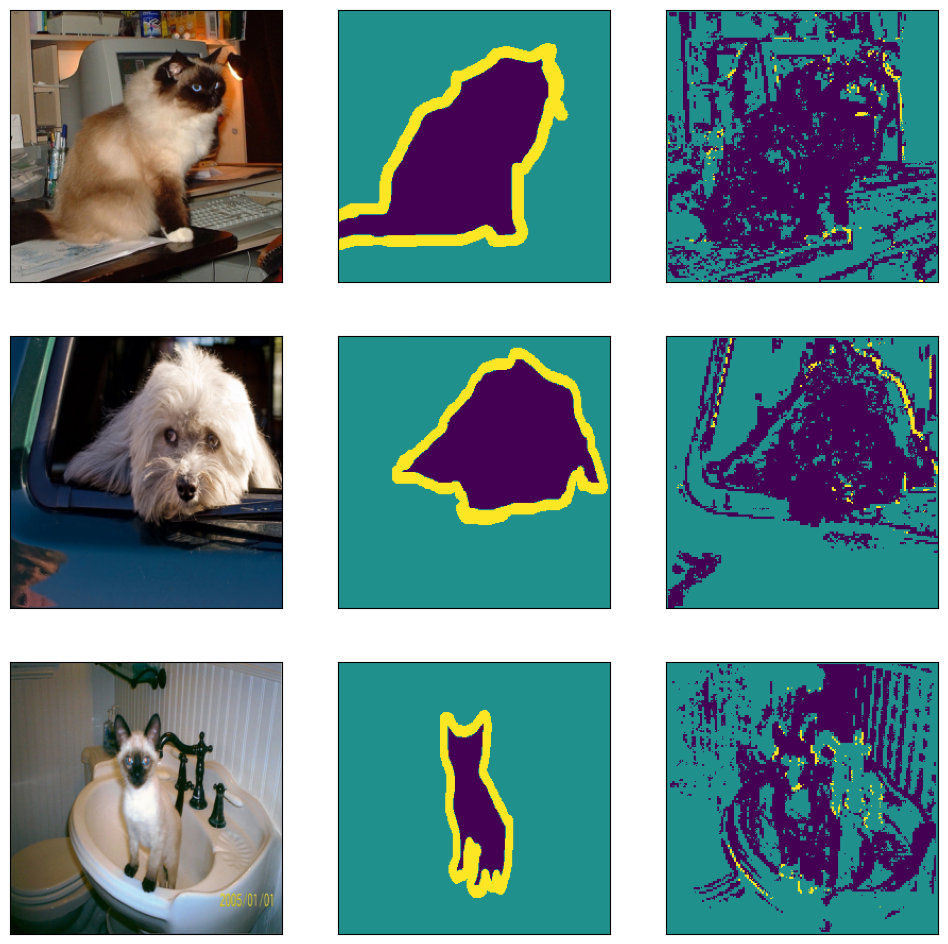

In [35]:
import random

# 저장된 모델 weight 로드
model = BaseModel(3, N_CLASSES, IMAGE_SIZE)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)
model.eval()

# 이미지 경로의 리스트 생성
img_path_list = sorted([
    os.path.join(IMAGE_PATH, name)
    for name in os.listdir(IMAGE_PATH)
    if name.endswith('.jpg')
])

# 맵 경로의 리스트 생성
map_path_list = sorted([
    os.path.join(MAP_PATH, name)
    for name in os.listdir(MAP_PATH)
    if name.endswith('.png')
])

# 랜덤한 세개의 인덱스 추출 후 이미지와 맵의 경로 저장
indices = random.sample(range(len(img_path_list) - 1), 3)
image_map_paths = {img_path_list[idx]: map_path_list[idx] for idx in indices}

# 이미지 transform 정의. 데이터셋 클래스와 같아야 함
transform = transforms.Compose([
transforms.Resize(IMAGE_SIZE),
transforms.ToTensor()
])

with torch.no_grad():
  figure, ax = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

  for i, (image, map) in enumerate(image_map_paths.items()):
    # 이미지 로드 후 transform. 데이터셋 클래스와 같은 작업
    image = Image.open(image).convert('RGB')
    image = transform(image).to(DEVICE)
    image = torch.unsqueeze(image, dim=0) # 배치 dimension 추가

    # 모델 통과 후 예측 맵 생성
    pred = model(image).squeeze()
    pred = torch.argmax(pred, dim=0) # logit이 가장 큰 class 선택
    pred = pred.cpu().numpy()
    pred = pred * 255   # 이미지로 표시하기 위해 255 곱함

    # 정답 맵 로드
    map = Image.open(map).convert('L')
    map = transform(map)
    map = torch.squeeze(map, dim=0)
    map = map * 255
    map -= 1

    # 이미지 plot
    image = image.squeeze().permute(1, 2, 0).cpu()
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(map)
    ax[i, 2].imshow(pred)

  # Save the plot
  figure.savefig(PRED_PLOT_PATH)